# Topic extraction with Non-negative Matrix Factorization and Latent Dirichlet Allocation

Modified from [Topic extraction with Non-negative Matrix Factorization and Latent Dirichlet Allocation](https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html)

In [1]:
from time import time

import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import NMF, LatentDirichletAllocation, MiniBatchNMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

n_samples = 2000
n_features = 1000
n_components = 10
n_top_words = 12
batch_size = 128
init = "nndsvda"

In [2]:
# Load the 20 newsgroups dataset and vectorize it. We use a few heuristics
# to filter out useless terms early on: the posts are stripped of headers,
# footers and quoted replies, and common English words, words occurring in
# only one document or in at least 95% of the documents are removed.

print("Loading dataset...")
data, _ = fetch_20newsgroups(
    shuffle=True,
    random_state=1,
    remove=("headers", "footers", "quotes"),
    return_X_y=True,
)
data_samples = data[:n_samples]
print(data_samples[0])

Loading dataset...
Well i'm not sure about the story nad it did seem biased. What
I disagree with is your statement that the U.S. Media is out to
ruin Israels reputation. That is rediculous. The U.S. media is
the most pro-israeli media in the world. Having lived in Europe
I realize that incidences such as the one described in the
letter have occured. The U.S. media as a whole seem to try to
ignore them. The U.S. is subsidizing Israels existance and the
Europeans are not (at least not to the same degree). So I think
that might be a reason they report more clearly on the
atrocities.
	What is a shame is that in Austria, daily reports of
the inhuman acts commited by Israeli soldiers and the blessing
received from the Government makes some of the Holocaust guilt
go away. After all, look how the Jews are treating other races
when they got power. It is unfortunate.



In [3]:
# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95, min_df=2, max_features=n_features, stop_words="english"
)
tfidf = tfidf_vectorizer.fit_transform(data_samples)
tfidf

Extracting tf-idf features for NMF...


<2000x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 51752 stored elements in Compressed Sparse Row format>

In [4]:
# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(
    max_df=0.95, min_df=2, max_features=n_features, stop_words="english"
)
tf = tf_vectorizer.fit_transform(data_samples)
tf

Extracting tf features for LDA...


<2000x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 51752 stored elements in Compressed Sparse Row format>

In [5]:
models = {
    'NMF(Frobenius norm)': NMF(n_components=n_components,random_state=1,init=init,beta_loss="frobenius",alpha_W=0.00005,alpha_H=0.00005,l1_ratio=1),
    'NMF(KL Divergence)': NMF(n_components=n_components,random_state=1,init=init,beta_loss="kullback-leibler", solver="mu", max_iter=1000,alpha_W=0.00005,alpha_H=0.00005,l1_ratio=0.5),
    'MiniBatchNMF(Frobenius norm)': MiniBatchNMF(n_components=n_components, random_state=1, batch_size=batch_size, init=init, beta_loss="frobenius", alpha_W=0.00005, alpha_H=0.00005,l1_ratio=0.5),
    'MiniBatchNMF(KL Divergence)': MiniBatchNMF(n_components=n_components, random_state=1, batch_size=batch_size, init=init, beta_loss="kullback-leibler", alpha_W=0.00005, alpha_H=0.00005,l1_ratio=0.5),
    'LDA': LatentDirichletAllocation(n_components=n_components,max_iter=5,learning_method="online",learning_offset=50.0,random_state=0)
}



 Fitting NMF(Frobenius norm) models with tf features, n_samples=2000 and n_features=1000...
done in 0.356s.


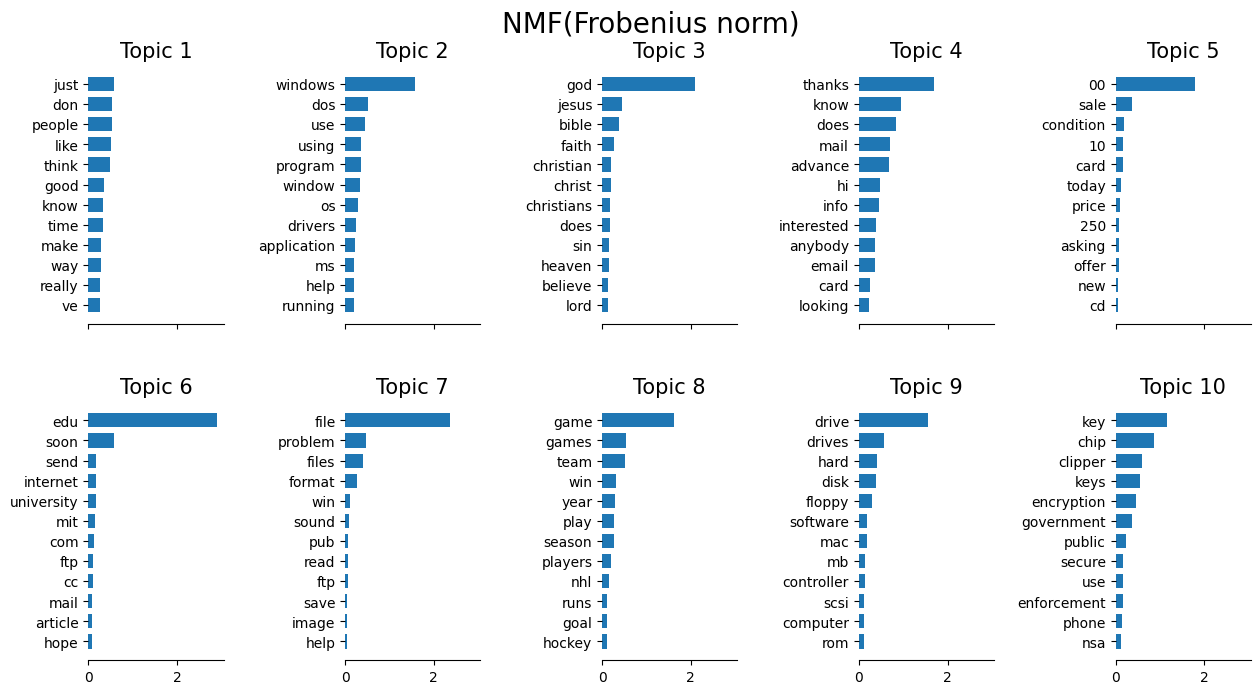

In [6]:
model_type = 'NMF(Frobenius norm)'
print(
    "\n" * 2,
    f"Fitting {model_type} models with tf features, n_samples=%d and n_features=%d..."
    % (n_samples, n_features),
)
model = models[model_type]
features = tfidf if model_type != 'LDA' else tf

t0 = time()
result = model.fit(features)
print("done in %0.3fs." % (time() - t0))

feature_names = tfidf_vectorizer.get_feature_names_out() if model_type != 'LDA' else tf_vectorizer.get_feature_names_out()

fig, axes = plt.subplots(2, 5, figsize=(15, 7), sharex=True)
axes = axes.flatten()
for topic_idx, topic in enumerate(model.components_):
    top_features_ind = topic.argsort()[-n_top_words:]
    top_features = feature_names[top_features_ind]
    weights = topic[top_features_ind]

    ax = axes[topic_idx]
    ax.barh(top_features, weights, height=0.7)
    ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 15})
    ax.tick_params(axis="both", which="major", labelsize=10)
    for i in "top right left".split():
        ax.spines[i].set_visible(False)
    fig.suptitle(model_type, fontsize=20)

plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
plt.show()

## Demo with Gradio

In [7]:
!pip install gradio

In [8]:

def plot_top_words(model, feature_names, n_top_words, title):
    fig1, axes = plt.subplots(1, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_[:5]):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig1.suptitle(title, fontsize=40)

    fig2, axes2 = plt.subplots(1, 5, figsize=(30, 15), sharex=True)
    axes2 = axes2.flatten()
    for topic_idx, topic in enumerate(model.components_[5:]):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes2[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +6}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        # fig2.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    return fig1, fig2




In [9]:
import gradio as gr

def topic_extraction(model_type):
    model = models[model_type]
    features = tfidf if model_type != 'LDA' else tf
    feature_names = tfidf_vectorizer.get_feature_names_out() if model_type != 'LDA' else tf_vectorizer.get_feature_names_out()
    m = model.fit(features)
    fig = plot_top_words(m, feature_names, n_top_words, f"Topics in {model_type}",)
    return fig

with gr.Blocks() as demo:
    gr.Interface(
        fn=topic_extraction,
        inputs=[gr.Dropdown(
              ["NMF(Frobenius norm)", "NMF(KL Divergence)", "MiniBatchNMF(Frobenius norm)", "MiniBatchNMF(KL Divergence)", "LDA"], label="Model", info="Choose a model")],
        outputs=[gr.Plot(label="topic extraction-1", format="png"), gr.Plot(label="topic extraction-2", format="png")],
        title='Topic Extraction'

    )



demo.launch(height = 800)

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://ff040e85437c07cbc5.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
